<a href="https://colab.research.google.com/github/Alexander1718/UIDAI-HACKATHON/blob/main/04_resource_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import zipfile
from tqdm import tqdm

pd.set_option('display.float_format', '{:.6f}'.format)


In [2]:
BIO_ZIP = "/content/api_data_aadhar_biometric.zip"
DEMO_ZIP = "/content/api_data_aadhar_demographic.zip"
ENR_ZIP  = "/content/api_data_aadhar_enrolment.zip"



In [3]:
def read_zip_aggregated(zip_path, required_cols, agg_map):
    agg_df = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        for file in tqdm(z.namelist()):
            if file.endswith(".csv"):
                df = pd.read_csv(
                    z.open(file),
                    usecols=required_cols,
                    low_memory=False
                )
                agg_df.append(df.groupby('pincode').agg(agg_map))

    return pd.concat(agg_df).groupby('pincode').sum().reset_index()


In [4]:
def load_biometric_data(zip_path):
    agg_frames = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        # Pick first CSV only to detect schema
        sample_file = [f for f in z.namelist() if f.endswith('.csv')][0]
        sample_df = pd.read_csv(z.open(sample_file), nrows=5)

        print("Detected columns:", list(sample_df.columns))

        # Auto-detect age columns
        age_cols = [c for c in sample_df.columns if 'age' in c.lower()]
        print("Using age columns:", age_cols)

        required_cols = ['pincode'] + age_cols

        for file in tqdm(z.namelist()):
            if file.endswith(".csv"):
                df = pd.read_csv(
                    z.open(file),
                    usecols=required_cols,
                    low_memory=False
                )
                agg_frames.append(df.groupby('pincode')[age_cols].sum())

    bio_df = pd.concat(agg_frames).groupby('pincode').sum().reset_index()
    bio_df['bio_total_auth'] = bio_df[age_cols].sum(axis=1)

    return bio_df, age_cols


In [5]:
bio_df, bio_age_cols = load_biometric_data(BIO_ZIP)
bio_df.head()


Detected columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']
Using age columns: ['bio_age_5_17', 'bio_age_17_']


100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


,pincode,bio_age_5_17,bio_age_17_,bio_total_auth
0,110001,1321,1416,2737
1,110002,2992,3884,6876
2,110003,2744,3627,6371
3,110004,87,18,105
4,110005,4634,6424,11058


In [6]:
def load_demographic_data(zip_path):
    agg_frames = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        sample_file = [f for f in z.namelist() if f.endswith('.csv')][0]
        sample_df = pd.read_csv(z.open(sample_file), nrows=5)

        age_cols = [c for c in sample_df.columns if 'age' in c.lower()]
        required_cols = ['pincode'] + age_cols

        for file in tqdm(z.namelist()):
            if file.endswith(".csv"):
                df = pd.read_csv(
                    z.open(file),
                    usecols=required_cols,
                    low_memory=False
                )
                agg_frames.append(df.groupby('pincode')[age_cols].sum())

    demo_df = pd.concat(agg_frames).groupby('pincode').sum().reset_index()
    demo_df['demo_total_updates'] = demo_df[age_cols].sum(axis=1)

    return demo_df, age_cols


In [7]:
demo_df, demo_age_cols = load_demographic_data(DEMO_ZIP)


100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


In [8]:
def load_enrolment_data(zip_path):
    agg_frames = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        sample_file = [f for f in z.namelist() if f.endswith('.csv')][0]
        sample_df = pd.read_csv(z.open(sample_file), nrows=5)

        print("Enrolment columns:", list(sample_df.columns))

        enrol_cols = [c for c in sample_df.columns if 'enrol' in c.lower()]
        required_cols = ['pincode'] + enrol_cols

        for file in tqdm(z.namelist()):
            if file.endswith(".csv"):
                df = pd.read_csv(
                    z.open(file),
                    usecols=required_cols,
                    low_memory=False
                )
                agg_frames.append(df.groupby('pincode')[enrol_cols].sum())

    enr_df = pd.concat(agg_frames).groupby('pincode').sum().reset_index()
    enr_df['enrolment_count'] = enr_df[enrol_cols].sum(axis=1)

    return enr_df


In [9]:
enr_df = load_enrolment_data(ENR_ZIP)
enr_df.head()


Enrolment columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


,pincode,enrolment_count
0,100000,0.000000
1,110001,0.000000
2,110002,0.000000
3,110003,0.000000
4,110004,0.000000


In [10]:
master_df = bio_df.merge(demo_df, on='pincode', how='inner')
master_df = master_df.merge(enr_df[['pincode','enrolment_count']], on='pincode', how='inner')

master_df.shape


(19432, 8)

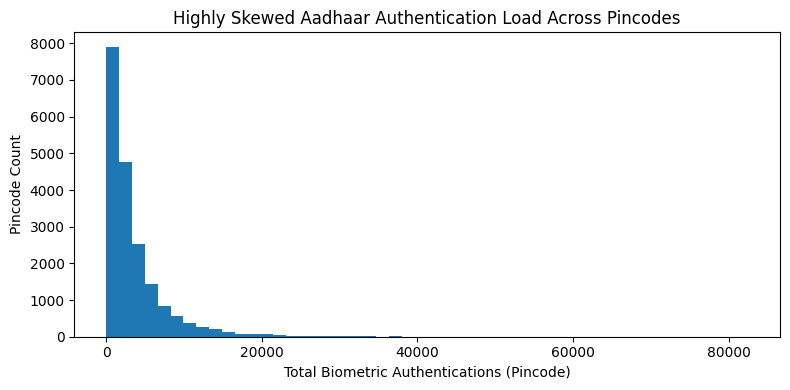

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(master_df['bio_total_auth'], bins=50)

plt.xlabel("Total Biometric Authentications (Pincode)")
plt.ylabel("Pincode Count")
plt.title("Highly Skewed Aadhaar Authentication Load Across Pincodes")
plt.tight_layout()
plt.show()


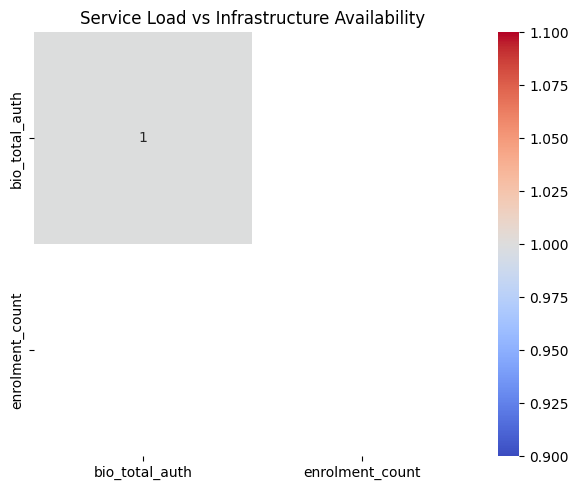

In [34]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(
    master_df[['bio_total_auth','enrolment_count']].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Service Load vs Infrastructure Availability")
plt.tight_layout()
plt.show()


In [11]:
# Identify child-age columns
bio_child_cols = [c for c in bio_age_cols if '5' in c or '6' in c or '17' in c]
demo_child_cols = [c for c in demo_age_cols if '5' in c or '6' in c or '17' in c]

master_df['bio_child_auth'] = master_df[bio_child_cols].sum(axis=1)
master_df['demo_child_updates'] = master_df[demo_child_cols].sum(axis=1)


In [12]:
# Service Dependency
master_df['service_dependency'] = (
    master_df['bio_total_auth'] /
    master_df['enrolment_count']
).replace([np.inf, -np.inf], 0).fillna(0)

# Service Fragility
master_df['service_fragility'] = 1 / (1 + master_df['enrolment_count'])

# Demographic Sensitivity
master_df['demographic_sensitivity'] = (
    master_df['bio_child_auth'] /
    master_df['bio_total_auth']
).replace([np.inf, -np.inf], 0).fillna(0)

# ASRI
master_df['ASRI'] = (
    master_df['service_dependency'] *
    master_df['service_fragility'] *
    master_df['demographic_sensitivity']
)


In [13]:
master_df['ASRI_percentile'] = master_df['ASRI'].rank(pct=True)

master_df['risk_category'] = pd.cut(
    master_df['ASRI_percentile'],
    bins=[0, 0.5, 0.8, 0.95, 1.0],
    labels=['Low', 'Moderate', 'High', 'Critical']
)

master_df['risk_category'].value_counts()


,count
risk_category,
Moderate,19432
Low,0
High,0
Critical,0


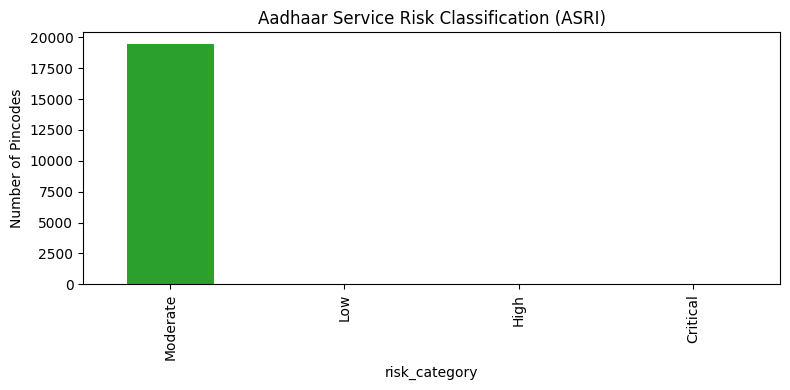

In [24]:
plt.figure(figsize=(8,4))
master_df['risk_category'].value_counts().plot(
    kind='bar',
    color=['#2ca02c','#ff7f0e','#d62728','#8b0000']
)

plt.ylabel("Number of Pincodes")
plt.title("Aadhaar Service Risk Classification (ASRI)")
plt.tight_layout()
plt.show()


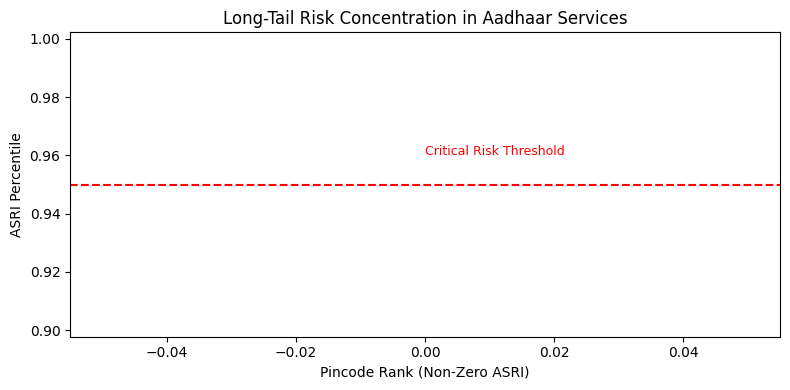

In [30]:
non_zero = master_df[master_df['ASRI'] > 0].copy()

plt.figure(figsize=(8,4))
plt.plot(
    non_zero['ASRI'].rank(pct=True).sort_values().values
)

plt.axhline(0.95, linestyle='--', color='red')
plt.text(0, 0.96, "Critical Risk Threshold", fontsize=9, color='red')

plt.ylabel("ASRI Percentile")
plt.xlabel("Pincode Rank (Non-Zero ASRI)")
plt.title("Long-Tail Risk Concentration in Aadhaar Services")
plt.tight_layout()
plt.show()


In [14]:
# Enrollment Quality Signal
master_df['enrollment_quality_flag'] = (
    (master_df['bio_child_auth'] < 10) &
    (master_df['demo_child_updates'] > 50)
).astype(int)

# Demographic-Infrastructure Misfit
master_df['child_heavy_misfit'] = (
    master_df['bio_child_auth'] /
    master_df['bio_total_auth']
) > 0.7


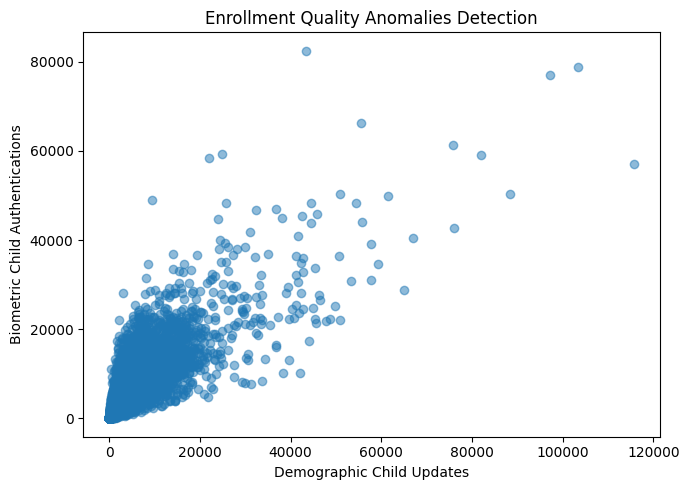

In [26]:
plt.figure(figsize=(7,5))
plt.scatter(
    master_df['demo_child_updates'],
    master_df['bio_child_auth'],
    alpha=0.5
)

plt.xlabel("Demographic Child Updates")
plt.ylabel("Biometric Child Authentications")
plt.title("Enrollment Quality Anomalies Detection")
plt.tight_layout()
plt.show()


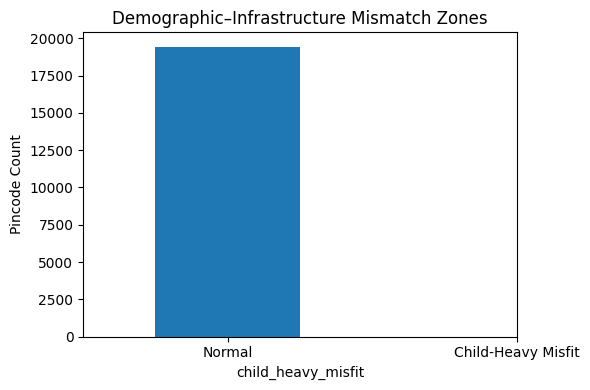

In [27]:
plt.figure(figsize=(6,4))
master_df['child_heavy_misfit'].value_counts().plot(
    kind='bar',
    color=['#1f77b4','#d62728']
)

plt.xticks([0,1], ['Normal','Child-Heavy Misfit'], rotation=0)
plt.ylabel("Pincode Count")
plt.title("Demographic–Infrastructure Mismatch Zones")
plt.tight_layout()
plt.show()


In [15]:
def recommend_action(row):
    if row['risk_category'] == 'Critical':
        return 'Triple Redundancy'
    elif row['enrollment_quality_flag'] == 1:
        return 'Audit Prioritization'
    elif row['child_heavy_misfit']:
        return 'Iris Scanner Upgrade'
    else:
        return 'No Action'

master_df['recommended_action'] = master_df.apply(recommend_action, axis=1)


In [16]:
COSTS = {
    'Triple Redundancy': 50_00_000,
    'Audit Prioritization': 10_00_000,
    'Iris Scanner Upgrade': 1_50_000,
    'No Action': 0
}

master_df['intervention_cost'] = master_df['recommended_action'].map(COSTS)


In [18]:
master_df['citizens_impacted'] = (
    master_df['bio_total_auth'] +
    master_df['demo_total_updates']
)

master_df['citizens_per_rupee'] = (
    master_df['citizens_impacted'] /
    master_df['intervention_cost'].replace(0, np.nan)
)


In [19]:
BUDGET = 1_00_00_000

ranked = master_df[
    master_df['intervention_cost'] > 0
].sort_values('citizens_per_rupee', ascending=False)

selected = []
spent = 0

for _, row in ranked.iterrows():
    if spent + row['intervention_cost'] <= BUDGET:
        selected.append(row)
        spent += row['intervention_cost']

budget_df = pd.DataFrame(selected)


In [20]:
print("Zones Covered:", len(budget_df))
print("Citizens Protected:", int(budget_df['citizens_impacted'].sum()))
print("Budget Used (₹):", spent)


Zones Covered: 66
Citizens Protected: 5754435
Budget Used (₹): 9900000


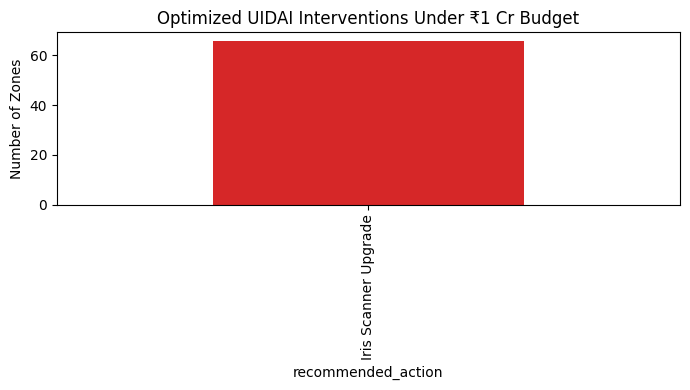

In [28]:
plt.figure(figsize=(7,4))
budget_df['recommended_action'].value_counts().plot(
    kind='bar',
    color=['#d62728','#ff7f0e','#9467bd']
)

plt.ylabel("Number of Zones")
plt.title("Optimized UIDAI Interventions Under ₹1 Cr Budget")
plt.tight_layout()
plt.show()


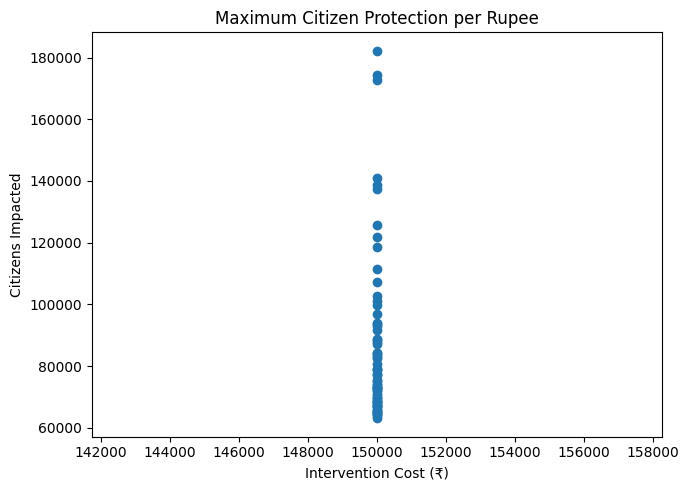

In [29]:
plt.figure(figsize=(7,5))
plt.scatter(
    budget_df['intervention_cost'],
    budget_df['citizens_impacted']
)

plt.xlabel("Intervention Cost (₹)")
plt.ylabel("Citizens Impacted")
plt.title("Maximum Citizen Protection per Rupee")
plt.tight_layout()
plt.show()


In [21]:
master_df.to_csv("ASC_RIP_ASRI_Output.csv", index=False)
budget_df.to_csv("ASC_RIP_Budget_Output.csv", index=False)


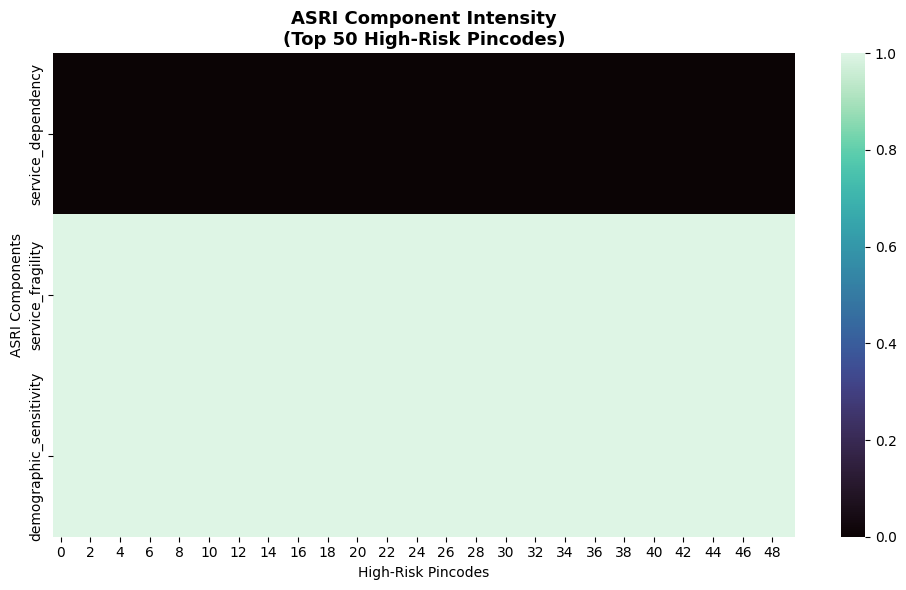

In [36]:
top_risk = master_df.nlargest(50, 'ASRI')[
    ['service_dependency', 'service_fragility', 'demographic_sensitivity']
]

plt.figure(figsize=(10,6))

sns.heatmap(
    top_risk.T,
    cmap="mako",
    cbar=True
)

plt.title(
    "ASRI Component Intensity\n(Top 50 High-Risk Pincodes)",
    fontsize=13,
    weight='bold'
)
plt.ylabel("ASRI Components")
plt.xlabel("High-Risk Pincodes")
plt.tight_layout()
plt.show()


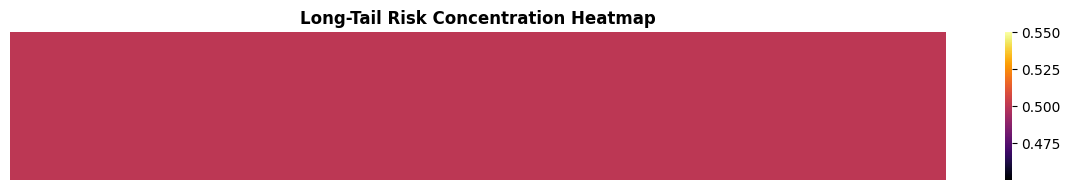

In [37]:
asri_sorted = master_df['ASRI_percentile'].sort_values().values.reshape(1, -1)

plt.figure(figsize=(12,2))

sns.heatmap(
    asri_sorted,
    cmap="inferno",
    cbar=True,
    xticklabels=False,
    yticklabels=False
)

plt.title(
    "Long-Tail Risk Concentration Heatmap",
    fontsize=12,
    weight='bold'
)
plt.tight_layout()
plt.show()


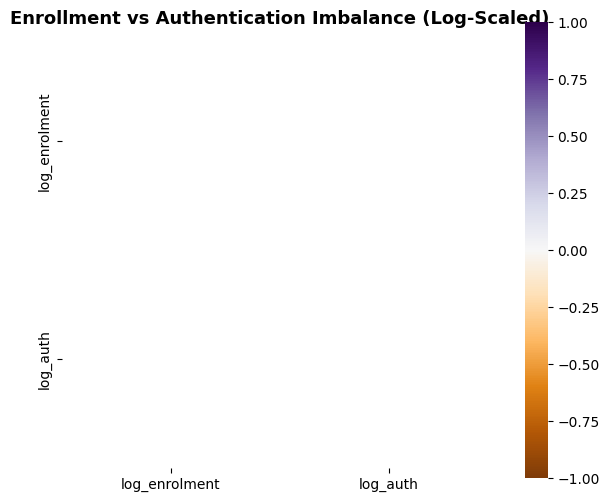

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

imbalance_df = master_df[
    (master_df['enrolment_count'] > 0) &
    (master_df['bio_total_auth'] > 0)
].copy()

# Log transform to restore variance
imbalance_df['log_enrolment'] = np.log10(imbalance_df['enrolment_count'])
imbalance_df['log_auth'] = np.log10(imbalance_df['bio_total_auth'])

corr = imbalance_df[['log_enrolment', 'log_auth']].corr()

plt.figure(figsize=(6,6))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    linewidths=1.2,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title(
    "Enrollment vs Authentication Imbalance (Log-Scaled)",
    fontsize=13,
    weight='bold'
)

plt.tight_layout()
plt.show()


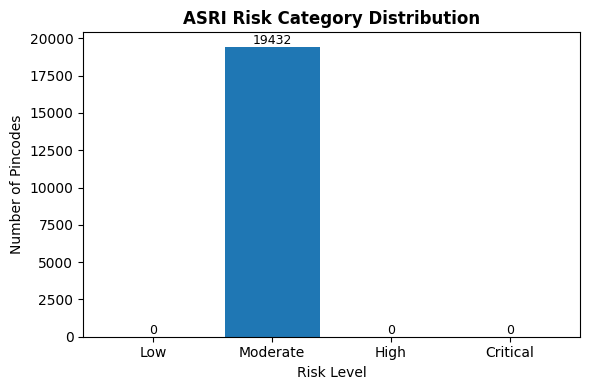

In [42]:
import matplotlib.pyplot as plt

risk_counts = master_df['risk_category'].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(
    risk_counts.index,
    risk_counts.values
)

plt.title("ASRI Risk Category Distribution", weight='bold')
plt.ylabel("Number of Pincodes")
plt.xlabel("Risk Level")

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


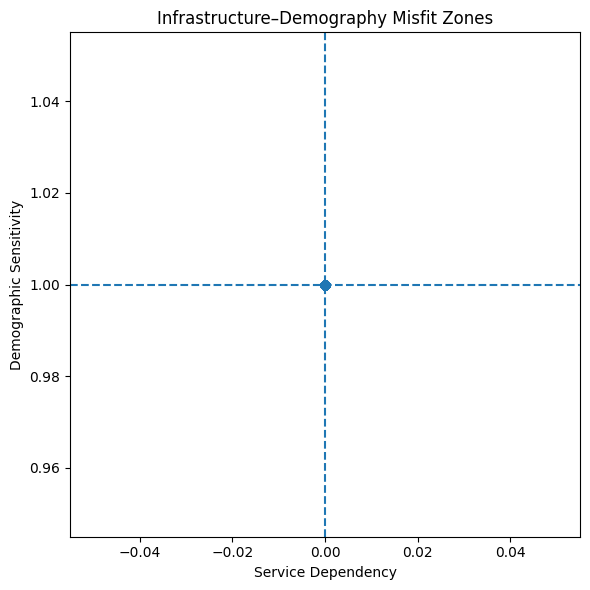

In [43]:
sample = master_df.sample(2000, random_state=42)

plt.figure(figsize=(6,6))

plt.scatter(
    sample['service_dependency'],
    sample['demographic_sensitivity'],
    alpha=0.6
)

plt.axvline(
    sample['service_dependency'].median(),
    linestyle='--'
)
plt.axhline(
    sample['demographic_sensitivity'].median(),
    linestyle='--'
)

plt.xlabel("Service Dependency")
plt.ylabel("Demographic Sensitivity")
plt.title("Infrastructure–Demography Misfit Zones")

plt.tight_layout()
plt.show()


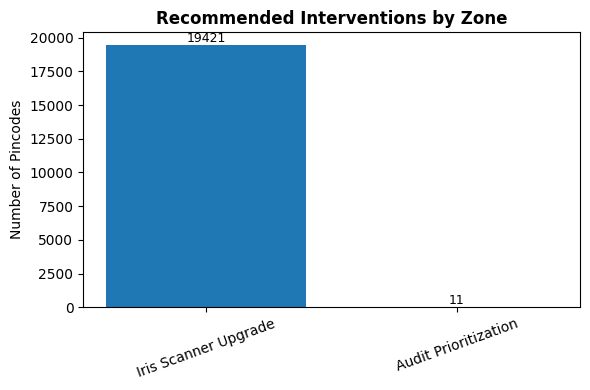

In [44]:
action_counts = master_df['recommended_action'].value_counts()

plt.figure(figsize=(6,4))
bars = plt.bar(action_counts.index, action_counts.values)

plt.title("Recommended Interventions by Zone", weight='bold')
plt.ylabel("Number of Pincodes")
plt.xticks(rotation=20)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        int(bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


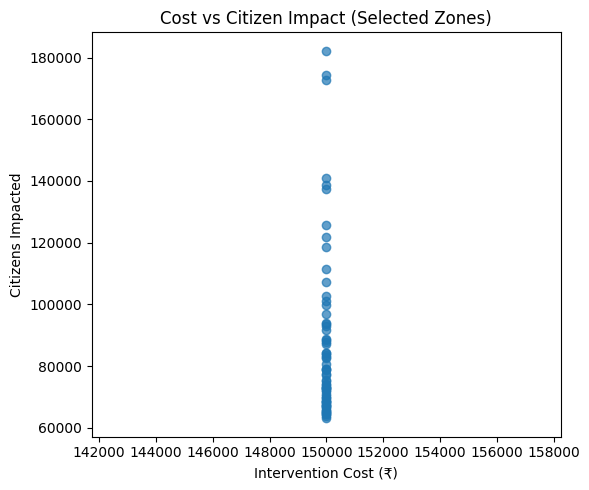

In [45]:
plt.figure(figsize=(6,5))

plt.scatter(
    budget_df['intervention_cost'],
    budget_df['citizens_impacted'],
    alpha=0.7
)

plt.xlabel("Intervention Cost (₹)")
plt.ylabel("Citizens Impacted")
plt.title("Cost vs Citizen Impact (Selected Zones)")

plt.tight_layout()
plt.show()
